## FLUX.1-dev fine tune with Lora on SageMaker  
***Note: Experimental only, since training scripts from kohya have not been public yet***
* Tested with SageMaker ml.g5.4xlarge notebook instance, 200GB storage
* Scripts and codes based on [kohya-ss/sd-scripts.](https://github.com/kohya-ss/sd-scripts/tree/sd3)
* Training images are from [here](https://github.com/shirayu/example_lora_training)  

### 1. Install dependencies

In [ ]:
!git clone -b sd3 https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!pip3 install torch==2.4.0 torchvision==0.19.0 --index-url https://download.pytorch.org/whl/cu124
!pip install -U -r requirements.txt
!pip install wandb

### 2. Download FLUX.1-dev model files
***Note: Official FLUX model repo needs authentification and accepting terms first, you need your "HF token"***

In [ ]:
import os
from huggingface_hub import login, hf_hub_download

# You need to replace below with your own. 
access_token = "YOUR_ACCESS_TOKEN_HERE"
login(access_token)

In [ ]:
model_dir = "./model"
os.makedirs(model_dir, exist_ok=True)

model_vae_repo_id = "black-forest-labs/FLUX.1-dev"
model_vae_files = ["flux1-dev.safetensors", "ae.safetensors"]
text_encoders_repo_id = "comfyanonymous/flux_text_encoders"
text_encoders_files = ["clip_l.safetensors", "t5xxl_fp16.safetensors"]

for file in model_vae_files:
    hf_hub_download(model_vae_repo_id, local_dir=model_dir, filename=file)
for file in text_encoders_files:
    hf_hub_download(text_encoders_repo_id, local_dir=model_dir, filename=file)

### 3. Initialize training environment
***Note: Refer "dataset-example.toml" to configure your own .toml file***

In [4]:
train_image_dir = "./image/sample"
output_image_dir = "./image/output"
lora_weight = "./lora_weight"
log = "./log"

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(lora_weight, exist_ok=True)
os.makedirs(log, exist_ok=True)

In [ ]:
%%writefile dataset.toml
[general]
enable_bucket = true
caption_extension = '.txt'
keep_tokens = 0

# DreamBooth caption based character datasets
[[datasets]]
resolution = 1024
# min_bucket_reso = 640
# max_bucket_reso = 1536
bucket_reso_steps = 32
batch_size = 2

[[datasets.subsets]]
image_dir = './image/sample'
num_repeats = 10

In [ ]:
%%writefile sample_prompt.toml
[prompt]
sample_steps = 20
width = 1024
height = 1024

[[prompt.subset]]
prompt = "wta, 1girl, looking at viewer, blue hair, short twintails, hair ornament, blue eyes, blush, smile, open mouth, shirt, skirt, kneehighs, brown footwear, standing, solo"
seed = 1000
[[prompt.subset]]
prompt = "wta, 1girl, looking at viewer, blue hair, short twintails, hair ornament, blue eyes, blush, smile, open mouth, shirt, skirt, kneehighs, brown footwear, standing, solo"
seed = 2000

In [ ]:
!git clone https://github.com/terrificdm/flux-sagemaker
!cp -r flux-sagemaker/dataset/* $train_image_dir
!rm -rf flux-sagemaker

In [8]:
# Fix missing libnvJitLink.so.12 issue of notebook

current_ld_lib_path = os.environ.get('LD_LIBRARY_PATH', '')
new_ld_lib_path = f"{os.path.expanduser('~')}/anaconda3/envs/python3/lib/python3.10/site-packages/nvidia/nvjitlink/lib:{current_ld_lib_path}"
os.environ['LD_LIBRARY_PATH'] = new_ld_lib_path

### 3. Train model

***Note: You need your wandb token if you want to monitor your training status***

In [ ]:
!accelerate launch --mixed_precision bf16 --num_cpu_threads_per_process 1 flux_train_network.py \
  --pretrained_model_name_or_path="$model_dir/flux1-dev.safetensors" \
  --clip_l="$model_dir/clip_l.safetensors" \
  --t5xxl="$model_dir/t5xxl_fp16.safetensors" \
  --ae="$model_dir/ae.safetensors" \
  --dataset_config="./dataset.toml" \
  --output_dir=lora_weight \
  --output_name="flux-lora-wta" \
  --network_module="networks.lora_flux" \
  --network_train_unet_only \
  --network_dim=64 \
  --network_alpha=32 \
  --timestep_sampling="sigmoid" \
  --model_prediction_type="raw" \
  --guidance_scale=1 \
  --loss_type="l2" \
  --t5xxl_max_token_length=512 \
  --learning_rate=1 \
  --lr_scheduler="cosine_with_restarts" \
  --lr_scheduler_num_cycles=1 \
  --optimizer_type="prodigy" \
  --max_train_epochs=10 \
  --save_every_n_epochs=2 \
  --save_model_as safetensors \
  --cache_latents_to_disk \
  --cache_text_encoder_outputs \
  --cache_text_encoder_outputs_to_disk \
  --sdpa \
  --fp8_base \
  --highvram \
  --gradient_checkpointing \
  --mixed_precision="bf16" \
  --full_bf16 \
  --save_precision="bf16" \
  --min_snr_gamma=5 \
  --sample_every_n_epochs=2 \
  --sample_prompts="./sample_prompt.toml" \
  --sample_sampler="euler_a" \
  --logging_dir=log \
  --log_with="all" \
  --log_tracker_name="flux_lora_wta" \
  --wandb_api_key="b005h93d3edff306e85ch44u72a3a5f69f1c73c7" # You need replace with you own

### 4. Mode inference testing

***Note: Since Diffusers community has not public any lib to load FLux Lora for now, we use Kohya's inference script here***

In [ ]:
!python ./flux_minimal_inference.py \
  --ckpt_path ./model/flux1-dev.safetensors \
  --clip_l ./model/clip_l.safetensors \
  --t5xxl ./model/t5xxl_fp16.safetensors \
  --ae ./model/ae.safetensors \
  --dtype bf16 \
  --prompt "wta, 1girl, blue hair, hair ornament, blue eyes, blush, smile, open mouth, shirt, skirt, kneehighs, short twintails, brown footwear, school bag, walking, solo" \
  --steps 50 \
  --width 1024 \
  --height 1024 \
  --out ./image/output \
  --flux_dtype fp8 \
  --offload \
  --merge_lora_weights \
  --lora_weights ./lora_weight/flux-lora-wta.safetensors

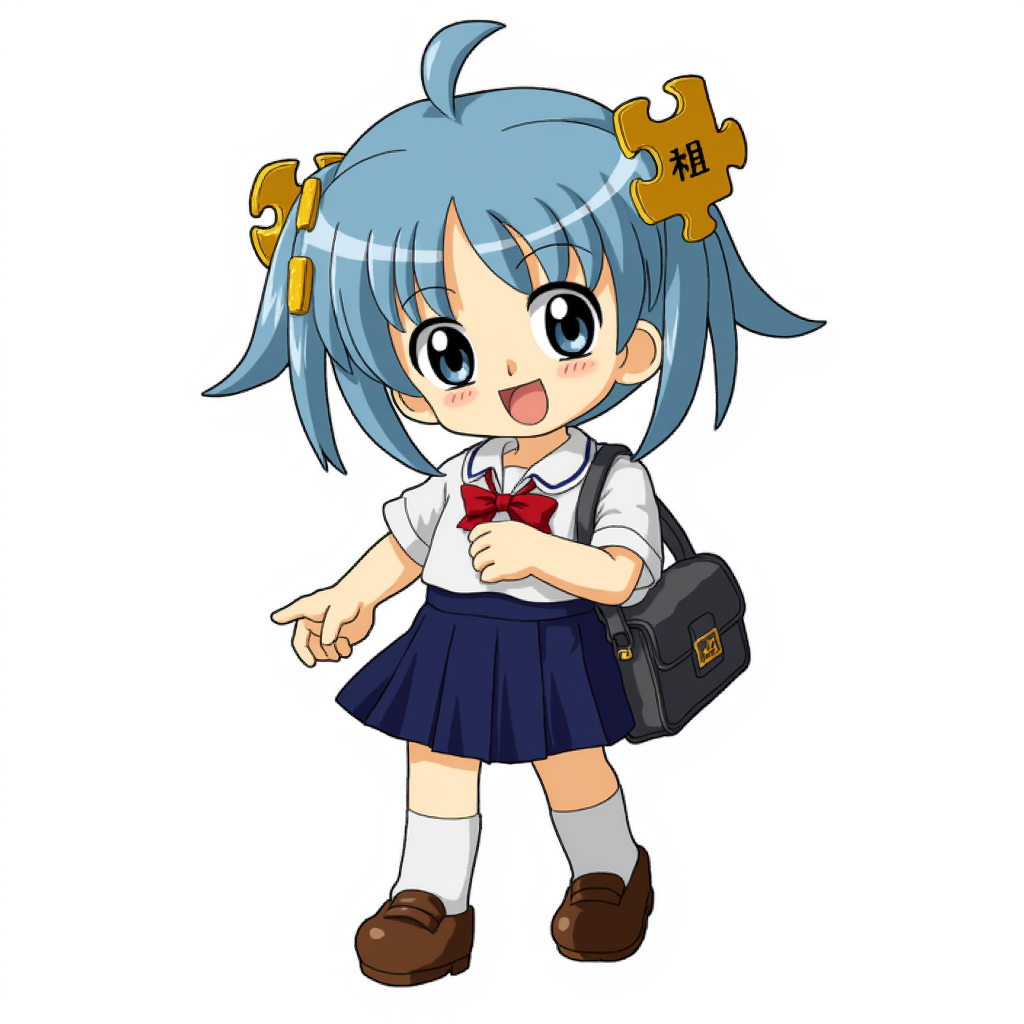

In [11]:
from glob import glob
from datetime import datetime
from PIL import Image

folder_path = "./image/output"
image_paths = glob(os.path.join(folder_path, "*.jpg")) + glob(os.path.join(folder_path, "*.png"))
latest_file = max(image_paths, key=os.path.getmtime)

img = Image.open(latest_file)
img.show()